Используемое устройство: cuda


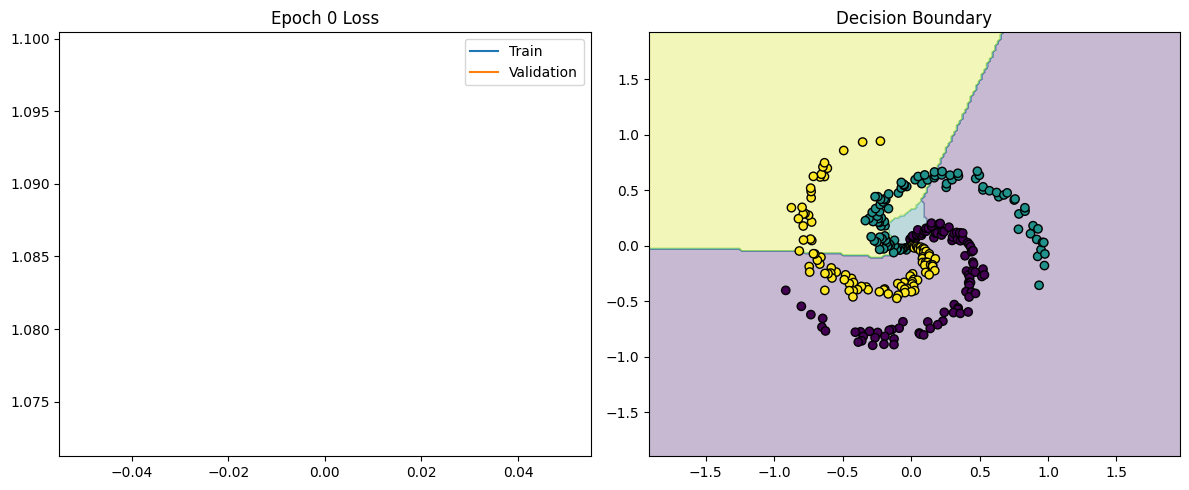

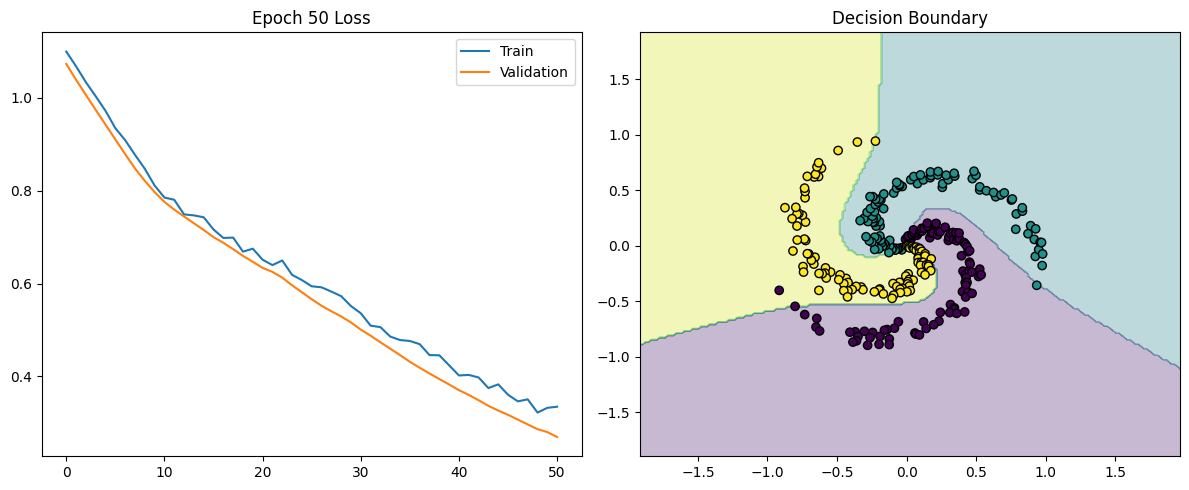

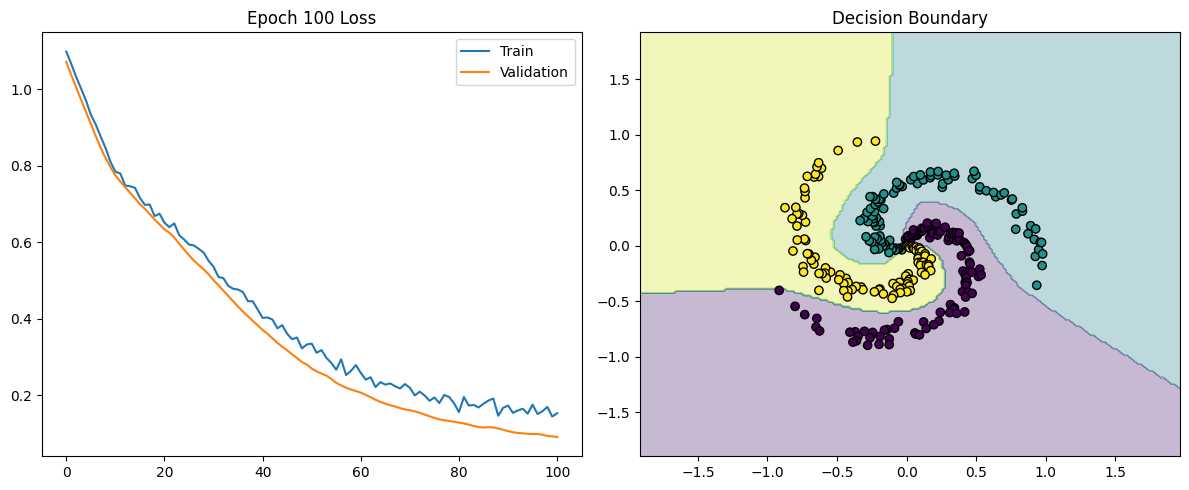

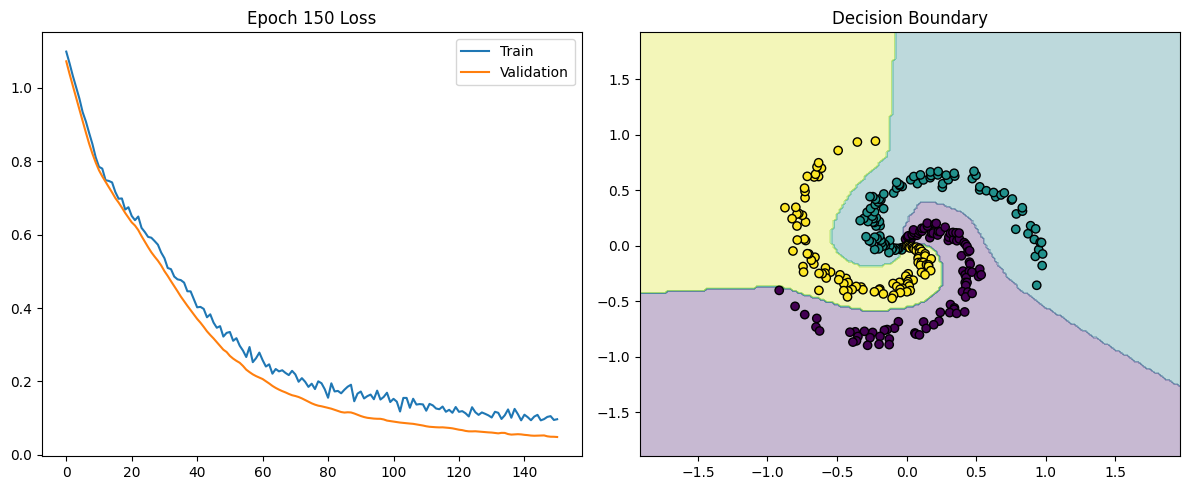

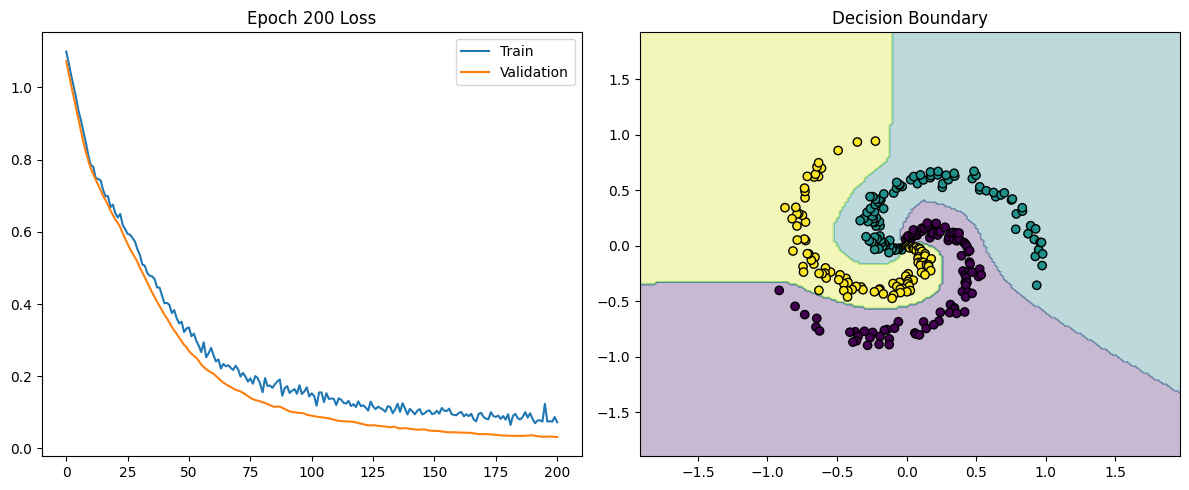

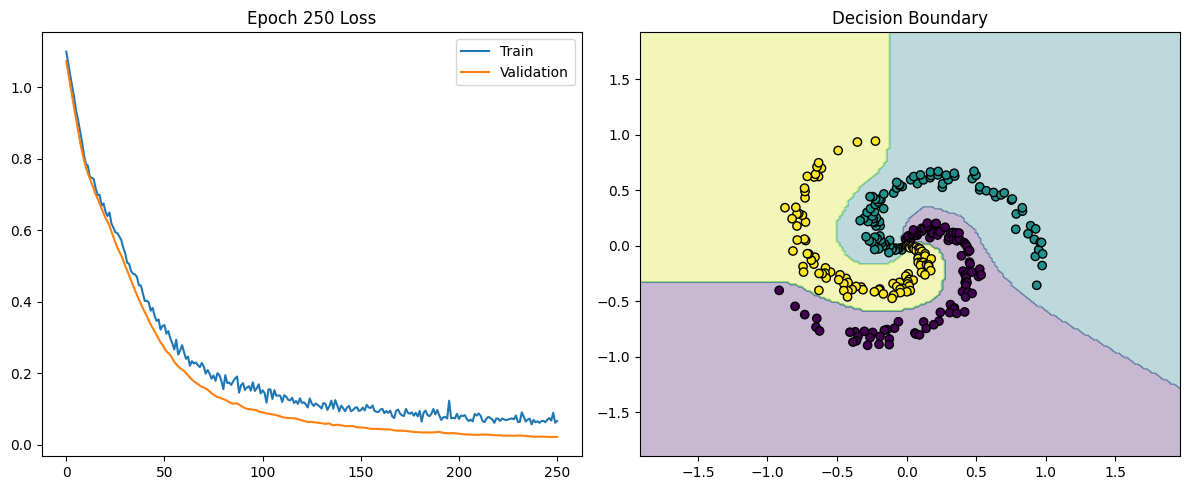

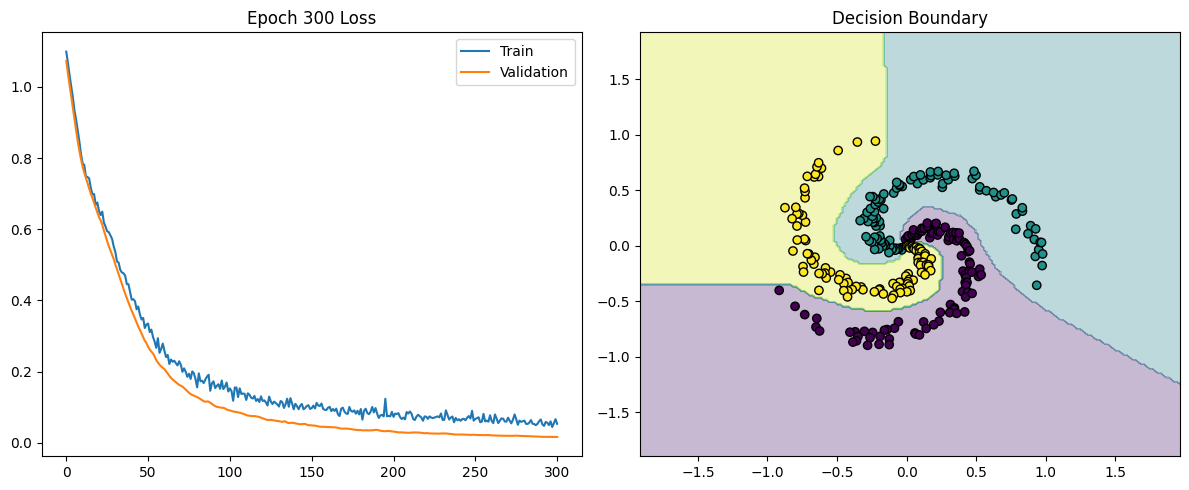

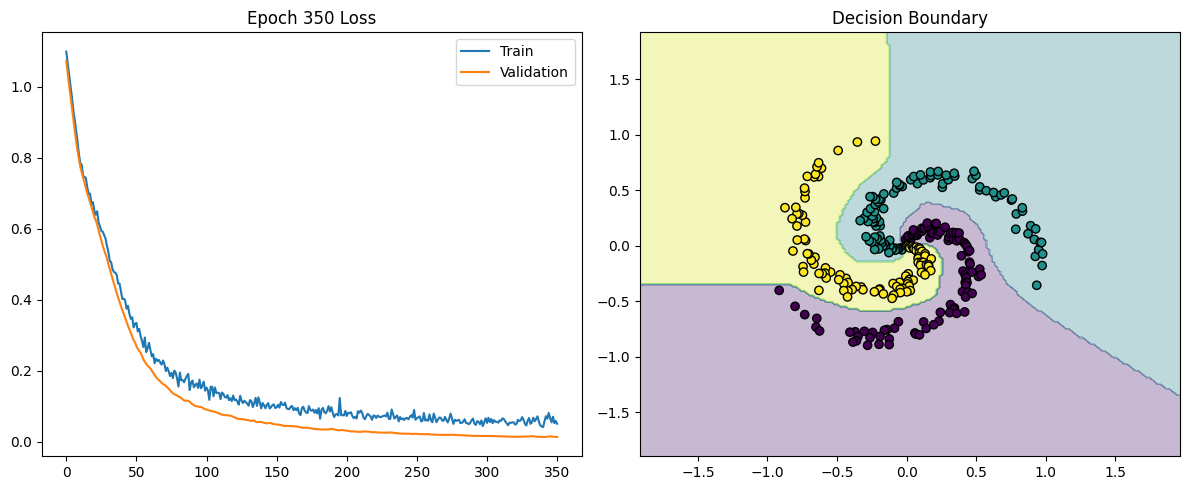

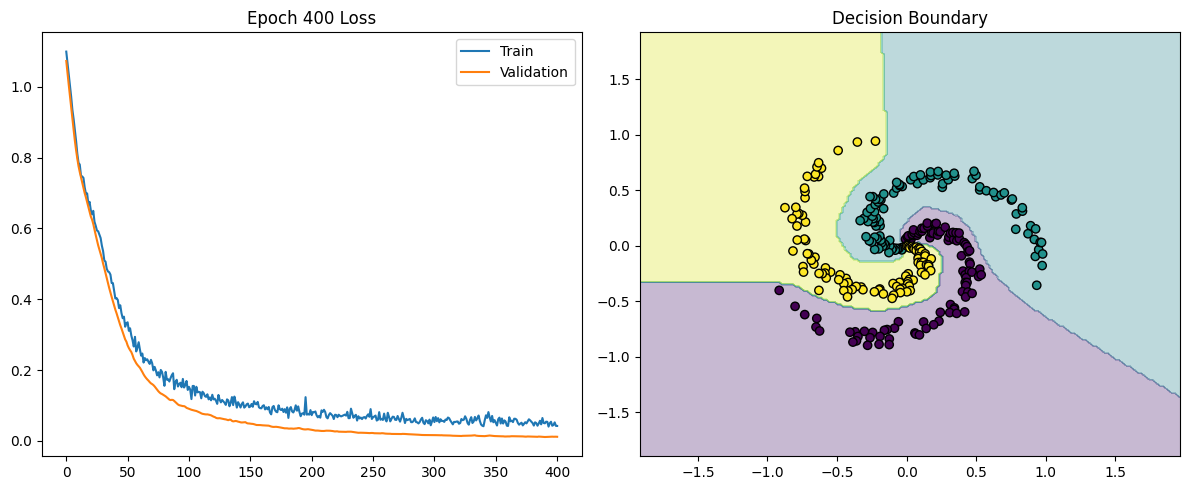

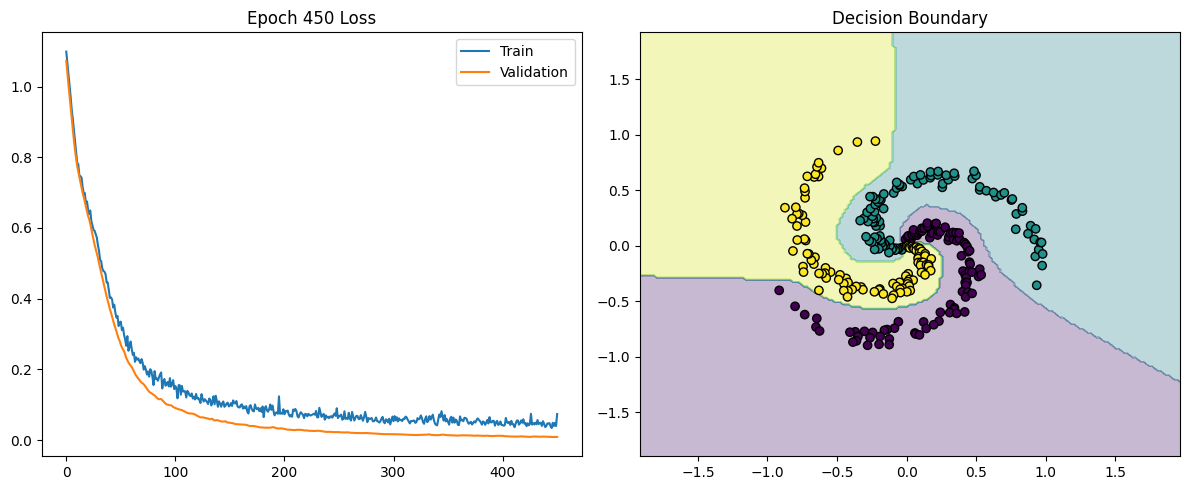

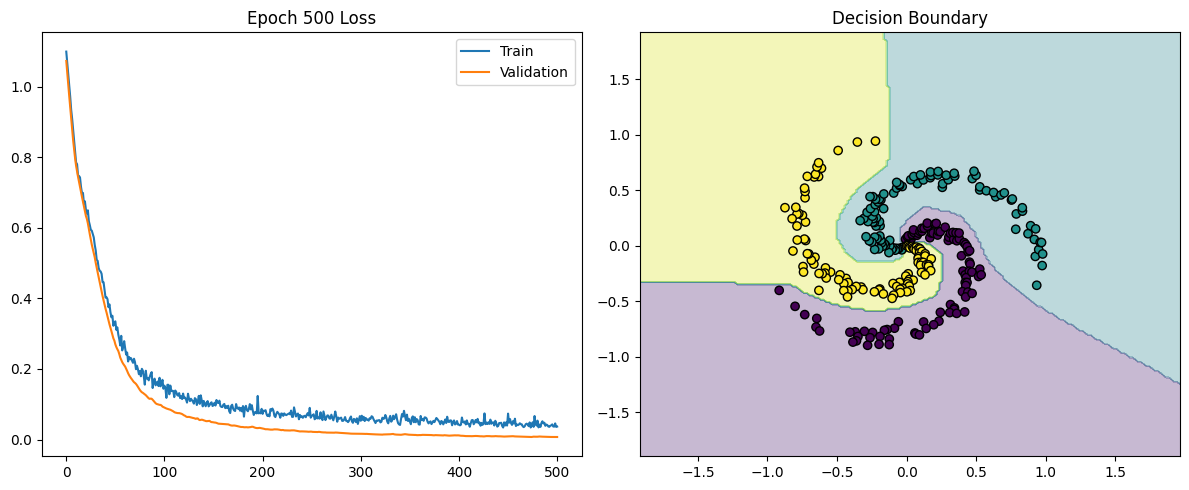

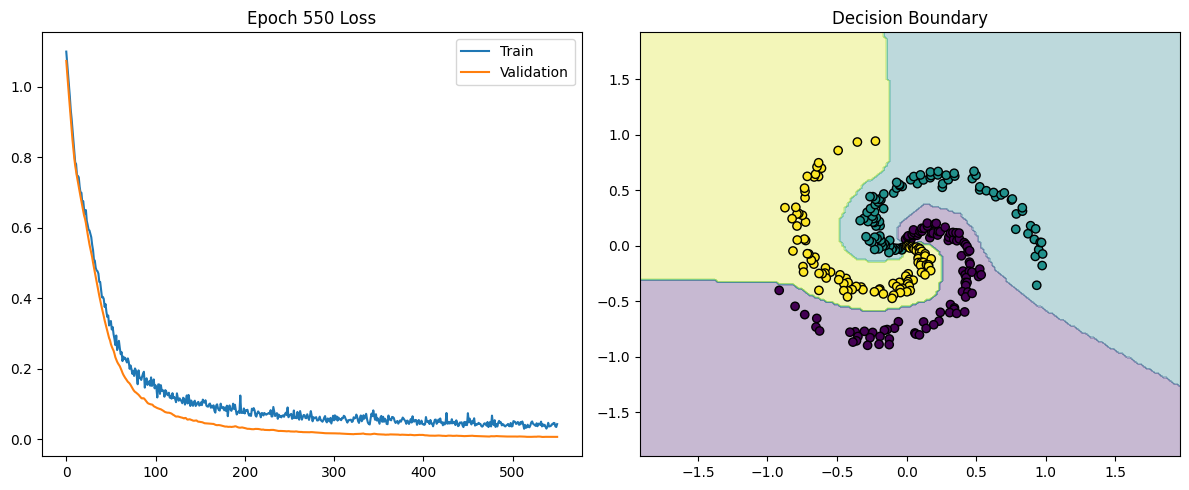

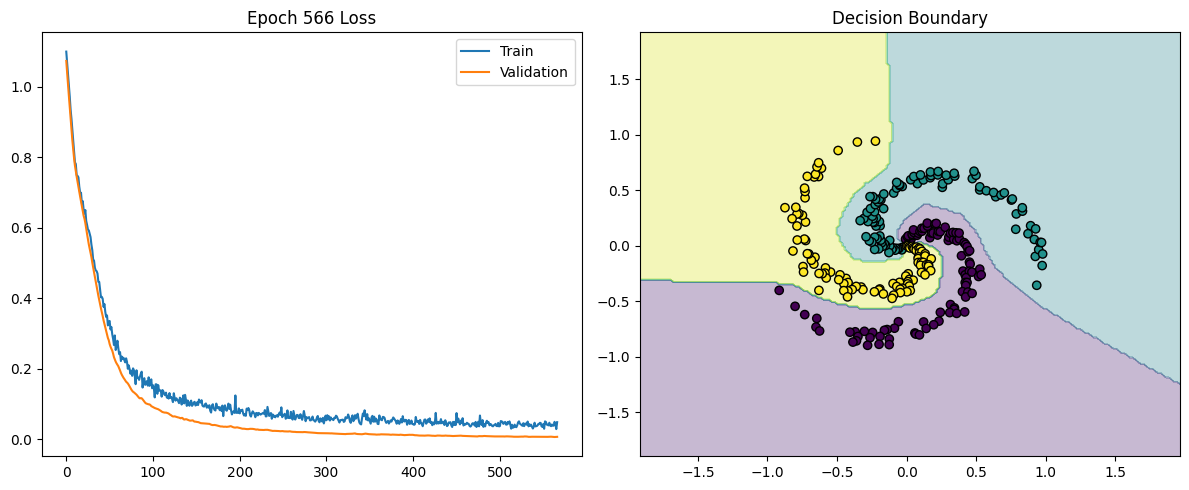

Ранняя остановка на эпохе 566


<All keys matched successfully>

In [ ]:
# -*- coding: utf-8 -*-
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 1. Конфигурация обучения
class Config:
    # Гиперпараметры
    SEED = 42
    BATCH_SIZE = 64
    NUM_EPOCHS = 1000
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4  # L2 регуляризация
    HIDDEN_SIZE = 128    # Размер скрытого слоя
    DROPOUT_PROB = 0.2   # Вероятность дропаута
    
    # Ранняя остановка
    PATIENCE = 50
    DELTA = 0.001
    
    # Визуализация
    PLOT_EVERY = 50

# 2. Инициализация устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# 3. Функция для генерации спиральных данных
def generate_spiral_data(n=100, k=3, noise=0.2):
    X = np.zeros((n*k, 2))
    y = np.zeros(n*k, dtype=np.int64)
    
    for class_num in range(k):
        ix = range(n*class_num, n*(class_num+1))
        r = np.linspace(0.0, 1, n)
        t = np.linspace(class_num*4, (class_num+1)*4, n) + np.random.randn(n)*noise
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = class_num
        
    return X, y

# 4. Создание и подготовка данных
X, y = generate_spiral_data(n=100, k=3, noise=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=Config.SEED)

# Конвертация в тензоры PyTorch
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

# DataLoader для батчей
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE)

# 5. Архитектура нейросети
class SpiralNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, Config.HIDDEN_SIZE)
        self.fc2 = torch.nn.Linear(Config.HIDDEN_SIZE, Config.HIDDEN_SIZE)
        self.fc3 = torch.nn.Linear(Config.HIDDEN_SIZE, 3)
        self.dropout = torch.nn.Dropout(Config.DROPOUT_PROB)
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                torch.nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

model = SpiralNet().to(device)

# 6. Оптимизация и функция потерь
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=Config.LEARNING_RATE, 
    weight_decay=Config.WEIGHT_DECAY
)

# убраны параметры verbose
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience=Config.PATIENCE//2
)

criterion = torch.nn.CrossEntropyLoss()

# 7. Обучение с ранней остановкой
best_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(Config.NUM_EPOCHS):
    # Тренировочный цикл
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Валидация
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
    
    # Средние потери
    train_loss = epoch_loss / len(train_loader)
    val_loss = val_loss / len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Обновление learning rate
    scheduler.step(val_loss)
    
    # Ранняя остановка
    if val_loss < best_loss - Config.DELTA:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
    
    # Визуализация
    if epoch % Config.PLOT_EVERY == 0 or patience_counter >= Config.PATIENCE:
        plt.figure(figsize=(12,5))
        
        # График потерь
        plt.subplot(121)
        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Validation')
        plt.title(f'Epoch {epoch} Loss')
        plt.legend()
        
        # Граница решений
        plt.subplot(122)
        h = 0.02
        x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
        y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        with torch.no_grad():
            Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device))
            Z = torch.argmax(Z, dim=1).cpu().numpy()
        
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.3)
        plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k')
        plt.title("Decision Boundary")
        
        plt.tight_layout()
        plt.show()
    
    if patience_counter >= Config.PATIENCE:
        print(f"Ранняя остановка на эпохе {epoch}")
        break

# 8. Загрузка лучшей модели
model.load_state_dict(torch.load("best_model.pth"))